<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_2_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition

The purpose of this project is to predict house prices (response) from predictor variables using Regression prediction techniques. The goal is to minimize the root mean squared (RMS) percentage error on the prediction of house sales price.

TODO: What type of problem is this?

# Data Collection

The data is a CSV file called HousingData.csv located on Google Drive. 

Here is a [link](https://drive.google.com/file/d/1KKbZ5xj750o7uOz7Tk84QlPiya4UX9FN/view?usp=sharing) to the data dictionary for the dataset.

## Imports

TODO: verify and remove any unneeded imports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

Data was provided on a Google Drive by the insructor.

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
# Load Data
data_path = '/drive/My Drive/Cohort_6/Projects/Project 2/Data/Housing Data.csv'
data = pd.read_csv(data_path)

# Data Cleaning

Data cleaning began with a high-level view of the columns to determine number of records, number of columns, volume of null (missing) values, and which values were continuous vs discrete.

Throughout the data cleaning process, the data specification was used to better understand the definition of columns and their values.

In [4]:
# Create copy of data that will be clean data
data_clean = data.copy();

In [5]:
# Get preliminary look at the data
data.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,905101070,20,RL,62.0,14299,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,4,3,1964,1964,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,513.0,LwQ,144.0,348.0,1005.0,GasA,...,Y,SBrkr,1005,0,0,1005,1.0,0.0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1964.0,Unf,2.0,440.0,TA,TA,N,0,0,0,0,0,0,NaN,MnPrv,NaN,0,7,2007,WD,Normal,115400
1,905101330,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,...,Y,SBrkr,1296,0,0,1296,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,CarPort,1967.0,Unf,2.0,516.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000
2,903454090,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,PConc,TA,TA,No,Unf,0.0,Unf,0.0,780.0,780.0,GasA,...,Y,SBrkr,780,595,0,1375,0.0,0.0,1,1,3,1,Gd,6,Typ,1,Gd,Detchd,1979.0,Unf,1.0,544.0,TA,TA,P,0,162,0,0,126,0,NaN,NaN,NaN,0,12,2007,WD,Normal,141000
3,533244030,60,FV,68.0,7379,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,484.0,Unf,0.0,491.0,975.0,GasA,...,Y,SBrkr,975,873,0,1848,1.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2000.0,RFn,2.0,592.0,TA,TA,Y,280,184,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254000
4,909252020,70,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Feedr,Norm,1Fam,2Story,7,9,1936,2007,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,PConc,Gd,Gd,No,ALQ,350.0,BLQ,210.0,0.0,560.0,GasA,...,Y,SBrkr,575,560,0,1135,1.0,0.0,1,0,3,1,Gd,6,Typ,0,NaN,Detchd,1971.0,RFn,2.0,576.0,TA,TA,Y,256,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2009,WD,Normal,155000


In [6]:
# Check data types and other information about the dataset
# 2637 records
# 81 columns
# Sale Price is target column
# PID is unique identifier for rows - not important for analysis
row_count = len(data.index)
print(row_count)
data.info()

2637
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637 entries, 0 to 2636
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2637 non-null   int64  
 1   MS SubClass      2637 non-null   int64  
 2   MS Zoning        2637 non-null   object 
 3   Lot Frontage     2188 non-null   float64
 4   Lot Area         2637 non-null   int64  
 5   Street           2637 non-null   object 
 6   Alley            180 non-null    object 
 7   Lot Shape        2637 non-null   object 
 8   Land Contour     2637 non-null   object 
 9   Utilities        2637 non-null   object 
 10  Lot Config       2637 non-null   object 
 11  Land Slope       2637 non-null   object 
 12  Neighborhood     2637 non-null   object 
 13  Condition 1      2637 non-null   object 
 14  Condition 2      2637 non-null   object 
 15  Bldg Type        2637 non-null   object 
 16  House Style      2637 non-null   object 
 17  Overall Q

## Identify nulls

Nulls were identified by column. Then a percentage was calculated for each column to identify which columns had a large percentage of null values. Any columns with null percentages over 80% were deleted. Any columns with null percentages below 80% were evaluated and either deleted or filled with acceptable non-null values based on data type and the data specification.

In [7]:
# Identify nulls by column
# Identified columns that have large percentage of nulls. 

# Get columns with nulls
nulls = data.isnull().sum()
nulls = nulls[nulls > 0]
print(nulls)
print('-'*20)
# See what percentage of the rows have nulls for columns containing nulls
nulls = (nulls/row_count) * 100
nulls_df = nulls.to_frame()
nulls_df.columns=['null_pct']
print('Large number of nulls')
nulls_df_big = nulls_df[nulls_df['null_pct'] > 40]
print(nulls_df_big)
print('-'*20)
print('Small number of nulls')
nulls_df_small = nulls_df[(nulls_df['null_pct'] < 40)]
print(nulls_df_small)

Lot Frontage       449
Alley             2457
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           73
Bsmt Cond           73
Bsmt Exposure       76
BsmtFin Type 1      73
BsmtFin SF 1         1
BsmtFin Type 2      74
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1284
Garage Type        145
Garage Yr Blt      147
Garage Finish      147
Garage Cars          1
Garage Area          1
Garage Qual        147
Garage Cond        147
Pool QC           2626
Fence             2109
Misc Feature      2541
dtype: int64
--------------------
Large number of nulls
               null_pct
Alley         93.174061
Fireplace Qu  48.691695
Pool QC       99.582859
Fence         79.977247
Misc Feature  96.359499
--------------------
Small number of nulls
                 null_pct
Lot Frontage    17.026925
Mas Vnr Type     0.872203
Mas Vnr Area     0.872203
Bsmt Qual        2.768297
Bsmt Cond        2.768297
Bsm

## Fill Missing Values

Value counts were taken on all columns with nulls. If there were a small number of nulls, then nulls were replaced with zero for continuous columns and whatever code was specified as None or NA in the data sheet for categorical data.

Changes were made directly in the dataset.

In [8]:
# Fill in null values based on data type and data specification
data_clean['Mas Vnr Type'].fillna('None', inplace=True)
data_clean['Mas Vnr Area'].fillna(0, inplace=True)
data_clean['Bsmt Cond'].fillna('NA', inplace=True)
data_clean['Bsmt Exposure'].fillna('NA', inplace=True)
data_clean['BsmtFin Type 1'].fillna('NA', inplace=True)
data_clean['BsmtFin SF 1'].fillna(0, inplace=True)
data_clean['Bsmt Unf SF'].fillna(0, inplace=True)
data_clean['Total Bsmt SF'].fillna(0, inplace=True)
data_clean['Bsmt Full Bath'].fillna(0, inplace=True)
data_clean['Bsmt Half Bath'].fillna(0, inplace=True)
data_clean['Garage Type'].fillna('NA', inplace=True)
data_clean['Garage Finish'].fillna('NA', inplace=True)
data_clean['Garage Cars'].fillna(0, inplace=True)

## Remove columns

After reviewing the data, columns were removed that were deemed unlikely to support a Sale Price prediction based on the following criteria:

* Remove non-predictor columns such as the row id.
* Remove columns that have a high percentage of null values (more than 80%).
* Remove columns that are redundant
* Remove columns that have very little variability in values; most fall in a single category.


In [9]:
# Remove unneeded columns based on criteria listed above.
data_clean.drop(['PID','Lot Frontage','Garage Yr Blt','Utilities','Land Slope','Land Contour',
               'Condition 2','Roof Matl','Exterior 2nd','Exter Qual','Bsmt Qual',
               'Garage Qual','Garage Cond','BsmtFin Type 2','BsmtFin SF 2','Heating',
               'Electrical','Functional','Alley','Pool QC','Misc Feature',
               'Fence','Fireplace Qu','Garage Area'], axis=1, inplace=True)


In [10]:
# Verify no nulls exist after data cleaned
data_clean.isnull().sum().sum()
# data_clean.info()


0

## Encode columns

After nulls were elminated and unnecessary columns were removed, remaining columns containing discrete non-numeric data were encoded (converted to numeric equivalents).

This process was necessary because the analysis engines used required numeric data to operate.

A dataset containing the original values was retained as a data dictionary to allow for translation between original and encoded values.

In [11]:
# Encode data so can run correlations to determine which columns to keep
labelencoder = LabelEncoder()
data_clean['Condition 1 Lb'] = labelencoder.fit_transform(data_clean['Condition 1'])
data_clean['MS Zoning Lb'] = labelencoder.fit_transform(data_clean['MS Zoning'])
data_clean['Street Lb'] = data_clean['Street'].replace({'Pave': 0, 'Grvl': 1})
data_clean['Lot Shape Lb'] = labelencoder.fit_transform(data_clean['Lot Shape'])
data_clean['Neighborhood Lb'] = labelencoder.fit_transform(data_clean['Neighborhood'])
data_clean['Lot Config Lb'] = labelencoder.fit_transform(data_clean['Lot Config'])
data_clean['Bldg Type Lb'] = labelencoder.fit_transform(data_clean['Bldg Type'])
data_clean['House Style Lb'] = labelencoder.fit_transform(data_clean['House Style'])
data_clean['Roof Style Lb'] = labelencoder.fit_transform(data_clean['Roof Style'])
data_clean['Exterior 1st Lb'] = labelencoder.fit_transform(data_clean['Exterior 1st'])
data_clean['Mas Vnr Type Lb'] = labelencoder.fit_transform(data_clean['Mas Vnr Type'])
data_clean['Bsmt Cond Lb'] = labelencoder.fit_transform(data_clean['Bsmt Cond'])
data_clean['Exter Cond Lb'] = labelencoder.fit_transform(data_clean['Exter Cond'])
data_clean['Foundation Lb'] = labelencoder.fit_transform(data_clean['Foundation'])
data_clean['Bsmt Exposure Lb'] = labelencoder.fit_transform(data_clean['Bsmt Exposure'])
data_clean['BsmtFin Type 1 Lb'] = labelencoder.fit_transform(data_clean['BsmtFin Type 1'])
data_clean['Heating QC Lb'] = labelencoder.fit_transform(data_clean['Heating QC'])
data_clean['Central Air Lb'] = data_clean['Central Air'].replace({'N': 0, 'Y': 1})
data_clean['Kitchen Qual Lb'] = labelencoder.fit_transform(data_clean['Kitchen Qual'])
data_clean['Garage Type Lb'] = labelencoder.fit_transform(data_clean['Garage Type'])
data_clean['Garage Finish Lb'] = labelencoder.fit_transform(data_clean['Garage Finish'])
data_clean['Paved Drive Lb'] = data_clean['Paved Drive'].replace({'N': 0, 'Y': 1, 'P': 2})
data_clean['Sale Type Lb'] = labelencoder.fit_transform(data_clean['Sale Type'])
data_clean['Sale Condition Lb'] = labelencoder.fit_transform(data_clean['Sale Condition'])

data_clean.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Lot Config,Neighborhood,Condition 1,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Mas Vnr Type,Mas Vnr Area,Exter Cond,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,...,Garage Type,Garage Finish,Garage Cars,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Condition 1 Lb,MS Zoning Lb,Street Lb,Lot Shape Lb,Neighborhood Lb,Lot Config Lb,Bldg Type Lb,House Style Lb,Roof Style Lb,Exterior 1st Lb,Mas Vnr Type Lb,Bsmt Cond Lb,Exter Cond Lb,Foundation Lb,Bsmt Exposure Lb,BsmtFin Type 1 Lb,Heating QC Lb,Central Air Lb,Kitchen Qual Lb,Garage Type Lb,Garage Finish Lb,Paved Drive Lb,Sale Type Lb,Sale Condition Lb
0,20,RL,14299,Pave,Reg,Inside,Sawyer,Feedr,1Fam,1Story,4,3,1964,1964,Gable,HdBoard,None,0.0,TA,CBlock,TA,No,Rec,513.0,348.0,1005.0,TA,Y,1005,0,0,1005,1.0,0.0,1,0,3,1,TA,5,...,Detchd,Unf,2.0,N,0,0,0,0,0,0,0,7,2007,WD,Normal,115400,1,5,0,3,22,4,0,2,1,6,3,5,4,1,4,5,4,1,3,5,3,0,9,4
1,90,RL,10791,Pave,Reg,Inside,Sawyer,Norm,Duplex,1Story,4,5,1967,1967,Gable,MetalSd,None,0.0,TA,Slab,NA,NA,NA,0.0,0.0,0.0,TA,Y,1296,0,0,1296,0.0,0.0,2,0,2,2,TA,6,...,CarPort,Unf,2.0,Y,0,0,0,0,0,0,500,10,2006,WD,Normal,90000,2,5,0,3,22,4,2,2,1,8,3,3,4,3,3,4,4,1,3,4,3,1,9,4
2,50,RM,9000,Pave,Reg,Inside,IDOTRR,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,Wd Sdng,None,0.0,Gd,PConc,TA,No,Unf,0.0,780.0,780.0,TA,Y,780,595,0,1375,0.0,0.0,1,1,3,1,Gd,6,...,Detchd,Unf,1.0,P,0,162,0,0,126,0,0,12,2007,WD,Normal,141000,2,6,0,3,11,4,0,0,1,14,3,5,2,2,4,6,4,1,2,5,3,2,9,4
3,60,FV,7379,Pave,IR1,Inside,Somerst,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,None,0.0,TA,PConc,TA,No,GLQ,484.0,491.0,975.0,Ex,Y,975,873,0,1848,1.0,0.0,2,1,3,1,Gd,7,...,Attchd,RFn,2.0,Y,280,184,0,0,0,0,0,4,2010,WD,Normal,254000,2,2,0,0,24,4,0,5,1,13,3,5,4,2,4,2,0,1,2,1,2,1,9,4
4,70,RL,7200,Pave,Reg,Inside,SWISU,Feedr,1Fam,2Story,7,9,1936,2007,Gable,Wd Sdng,None,0.0,Gd,PConc,Gd,No,ALQ,350.0,0.0,560.0,Ex,Y,575,560,0,1135,1.0,0.0,1,0,3,1,Gd,6,...,Detchd,RFn,2.0,Y,256,0,0,0,0,0,0,4,2009,WD,Normal,155000,1,5,0,3,21,4,0,5,1,14,3,2,2,2,4,0,0,1,2,5,2,1,9,4


In [12]:
# Create copy that contains only encoded and numeric values. 
# TODO: change code to drop columns based on data type being non-numeric
data_enc = data_clean.copy()

data_enc.drop(['MS Zoning','Street','Lot Shape','Neighborhood','Lot Config','Bldg Type',
               'House Style','Roof Style','Exterior 1st','Mas Vnr Type','Bsmt Cond',
               'Exter Cond','Foundation','Bsmt Exposure','BsmtFin Type 1','Heating QC',
               'Central Air','Kitchen Qual','Garage Type','Garage Finish','Paved Drive',
               'Sale Type','Sale Condition','Condition 1'], axis=1, inplace=True)

# Verify all values have been encoded.
data_enc.head()


,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Condition 1 Lb,MS Zoning Lb,Street Lb,Lot Shape Lb,Neighborhood Lb,Lot Config Lb,Bldg Type Lb,House Style Lb,Roof Style Lb,Exterior 1st Lb,Mas Vnr Type Lb,Bsmt Cond Lb,Exter Cond Lb,Foundation Lb,Bsmt Exposure Lb,BsmtFin Type 1 Lb,Heating QC Lb,Central Air Lb,Kitchen Qual Lb,Garage Type Lb,Garage Finish Lb,Paved Drive Lb,Sale Type Lb,Sale Condition Lb
0,20,14299,4,3,1964,1964,0.0,513.0,348.0,1005.0,1005,0,0,1005,1.0,0.0,1,0,3,1,5,0,2.0,0,0,0,0,0,0,0,7,2007,115400,1,5,0,3,22,4,0,2,1,6,3,5,4,1,4,5,4,1,3,5,3,0,9,4
1,90,10791,4,5,1967,1967,0.0,0.0,0.0,0.0,1296,0,0,1296,0.0,0.0,2,0,2,2,6,0,2.0,0,0,0,0,0,0,500,10,2006,90000,2,5,0,3,22,4,2,2,1,8,3,3,4,3,3,4,4,1,3,4,3,1,9,4
2,50,9000,6,6,1937,1950,0.0,0.0,780.0,780.0,780,595,0,1375,0.0,0.0,1,1,3,1,6,1,1.0,0,162,0,0,126,0,0,12,2007,141000,2,6,0,3,11,4,0,0,1,14,3,5,2,2,4,6,4,1,2,5,3,2,9,4
3,60,7379,8,5,2000,2000,0.0,484.0,491.0,975.0,975,873,0,1848,1.0,0.0,2,1,3,1,7,1,2.0,280,184,0,0,0,0,0,4,2010,254000,2,2,0,0,24,4,0,5,1,13,3,5,4,2,4,2,0,1,2,1,2,1,9,4
4,70,7200,7,9,1936,2007,0.0,350.0,0.0,560.0,575,560,0,1135,1.0,0.0,1,0,3,1,6,0,2.0,256,0,0,0,0,0,0,4,2009,155000,1,5,0,3,21,4,0,5,1,14,3,2,2,2,4,0,0,1,2,5,2,1,9,4


# Exploratory Data Analysis (EDA)

## Correlations

1. Identify correlations with SalePrice. Remove any predictors that do not have an effect on SalePrice (i.e. low correlation.
1. Identify correlations between predictors. Remove some predictors that are highly correlated as they are extraneous for this analysis.

Initially I looked at correlations as low as 40%. But further analysis showed blah blah blah.... TODO: figure out how to word this better.

In [23]:
# Note: Some items have low correlations when I would have expected higher correlation
# with sale price based on my personal house purchasing/selling experience.

# Look at clean data to see which columns can be used as predictors
corr = data_enc.corr()['SalePrice'].round(2)
correlated_vars = abs(corr).sort_values(ascending=False)
correlated_vars

# Keep predictors that have correlation over 50% with SalePrice - 5 columns to explore further.
# Overall Qual        0.805016
# Gr Liv Area         0.705482
# Garage Cars         0.646874
# Kitchen Qual Lb     0.629955
# 1st Flr SF          0.618247  # highly correlated with Gr Liv Area so disregard
# Year Built          0.562777
# Full Bath           0.542386
# Year Remod/Add      0.539932  # same as year built if no remodel took place so disregard


SalePrice          1.00
Overall Qual       0.81
Gr Liv Area        0.71
Garage Cars        0.65
Kitchen Qual Lb    0.63
Total Bsmt SF      0.63
1st Flr SF         0.62
Year Built         0.56
Full Bath          0.54
Year Remod/Add     0.54
Name: SalePrice, dtype: float64

In [25]:
# TODO: Do I keep this? Or just worry about correlation with sale price?
corrs = data_enc.corr().round(2).unstack().abs()
corrs = corrs[corrs < 1]
corrs = corrs.sort_values(ascending=False)
corrs

Overall Qual    SalePrice         0.81
SalePrice       Overall Qual      0.81
Total Bsmt SF   1st Flr SF        0.78
1st Flr SF      Total Bsmt SF     0.78
SalePrice       Gr Liv Area       0.71
                                  ... 
Year Remod/Add  Total Bsmt SF     0.30
1st Flr SF      Year Remod/Add    0.24
Year Built      Gr Liv Area       0.24
Year Remod/Add  1st Flr SF        0.24
Gr Liv Area     Year Built        0.24
Length: 90, dtype: float64

In [14]:
# Drop columns with low correlation to SalePrice
cols_to_drop = correlated_vars.to_frame()
cols_to_drop = cols_to_drop[cols_to_drop['SalePrice'] < .50]
for row in range(len(cols_to_drop.index)):
  data_enc.drop(cols_to_drop.index[row], inplace=True, axis=1)

data_enc.head()

,Overall Qual,Year Built,Year Remod/Add,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Garage Cars,SalePrice,Kitchen Qual Lb
0,4,1964,1964,1005.0,1005,1005,1,2.0,115400,3
1,4,1967,1967,0.0,1296,1296,2,2.0,90000,3
2,6,1937,1950,780.0,780,1375,1,1.0,141000,2
3,8,2000,2000,975.0,975,1848,2,2.0,254000,2
4,7,1936,2007,560.0,575,1135,1,2.0,155000,2


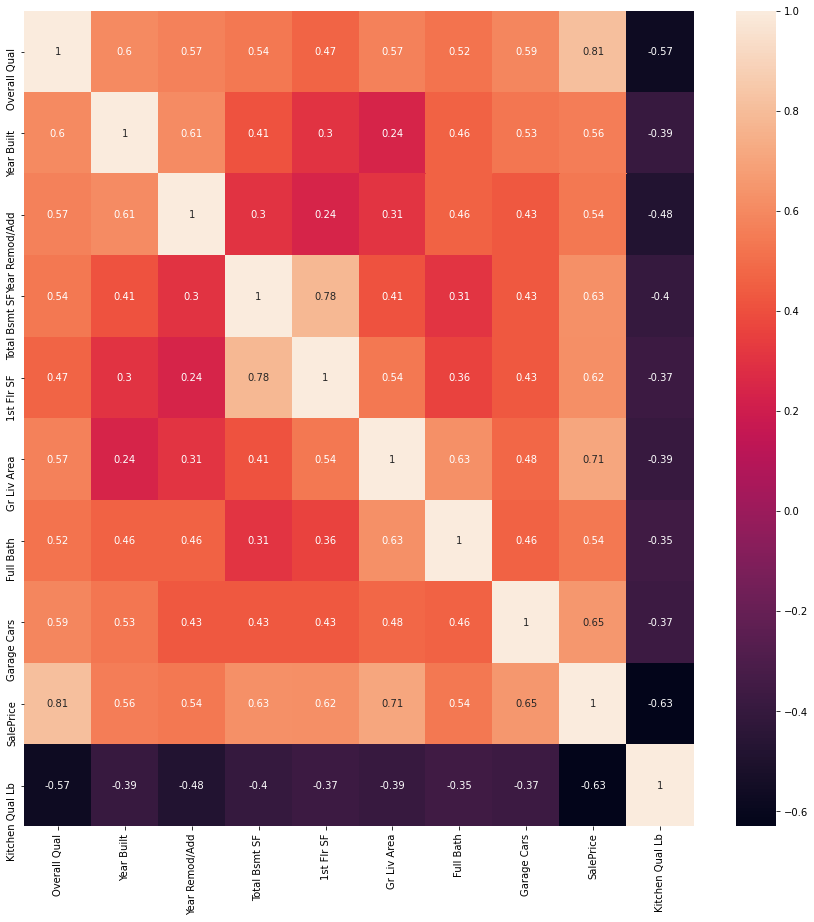

In [15]:
# Create correlation plot to see if any of the remaining predictors are highly correlated.
# If they are, then we can further reduce the number of predictors as unnecessary
#  since we don't need every predictor. 
plt.figure(figsize=(15,15))
correlation_matrix = data_enc.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

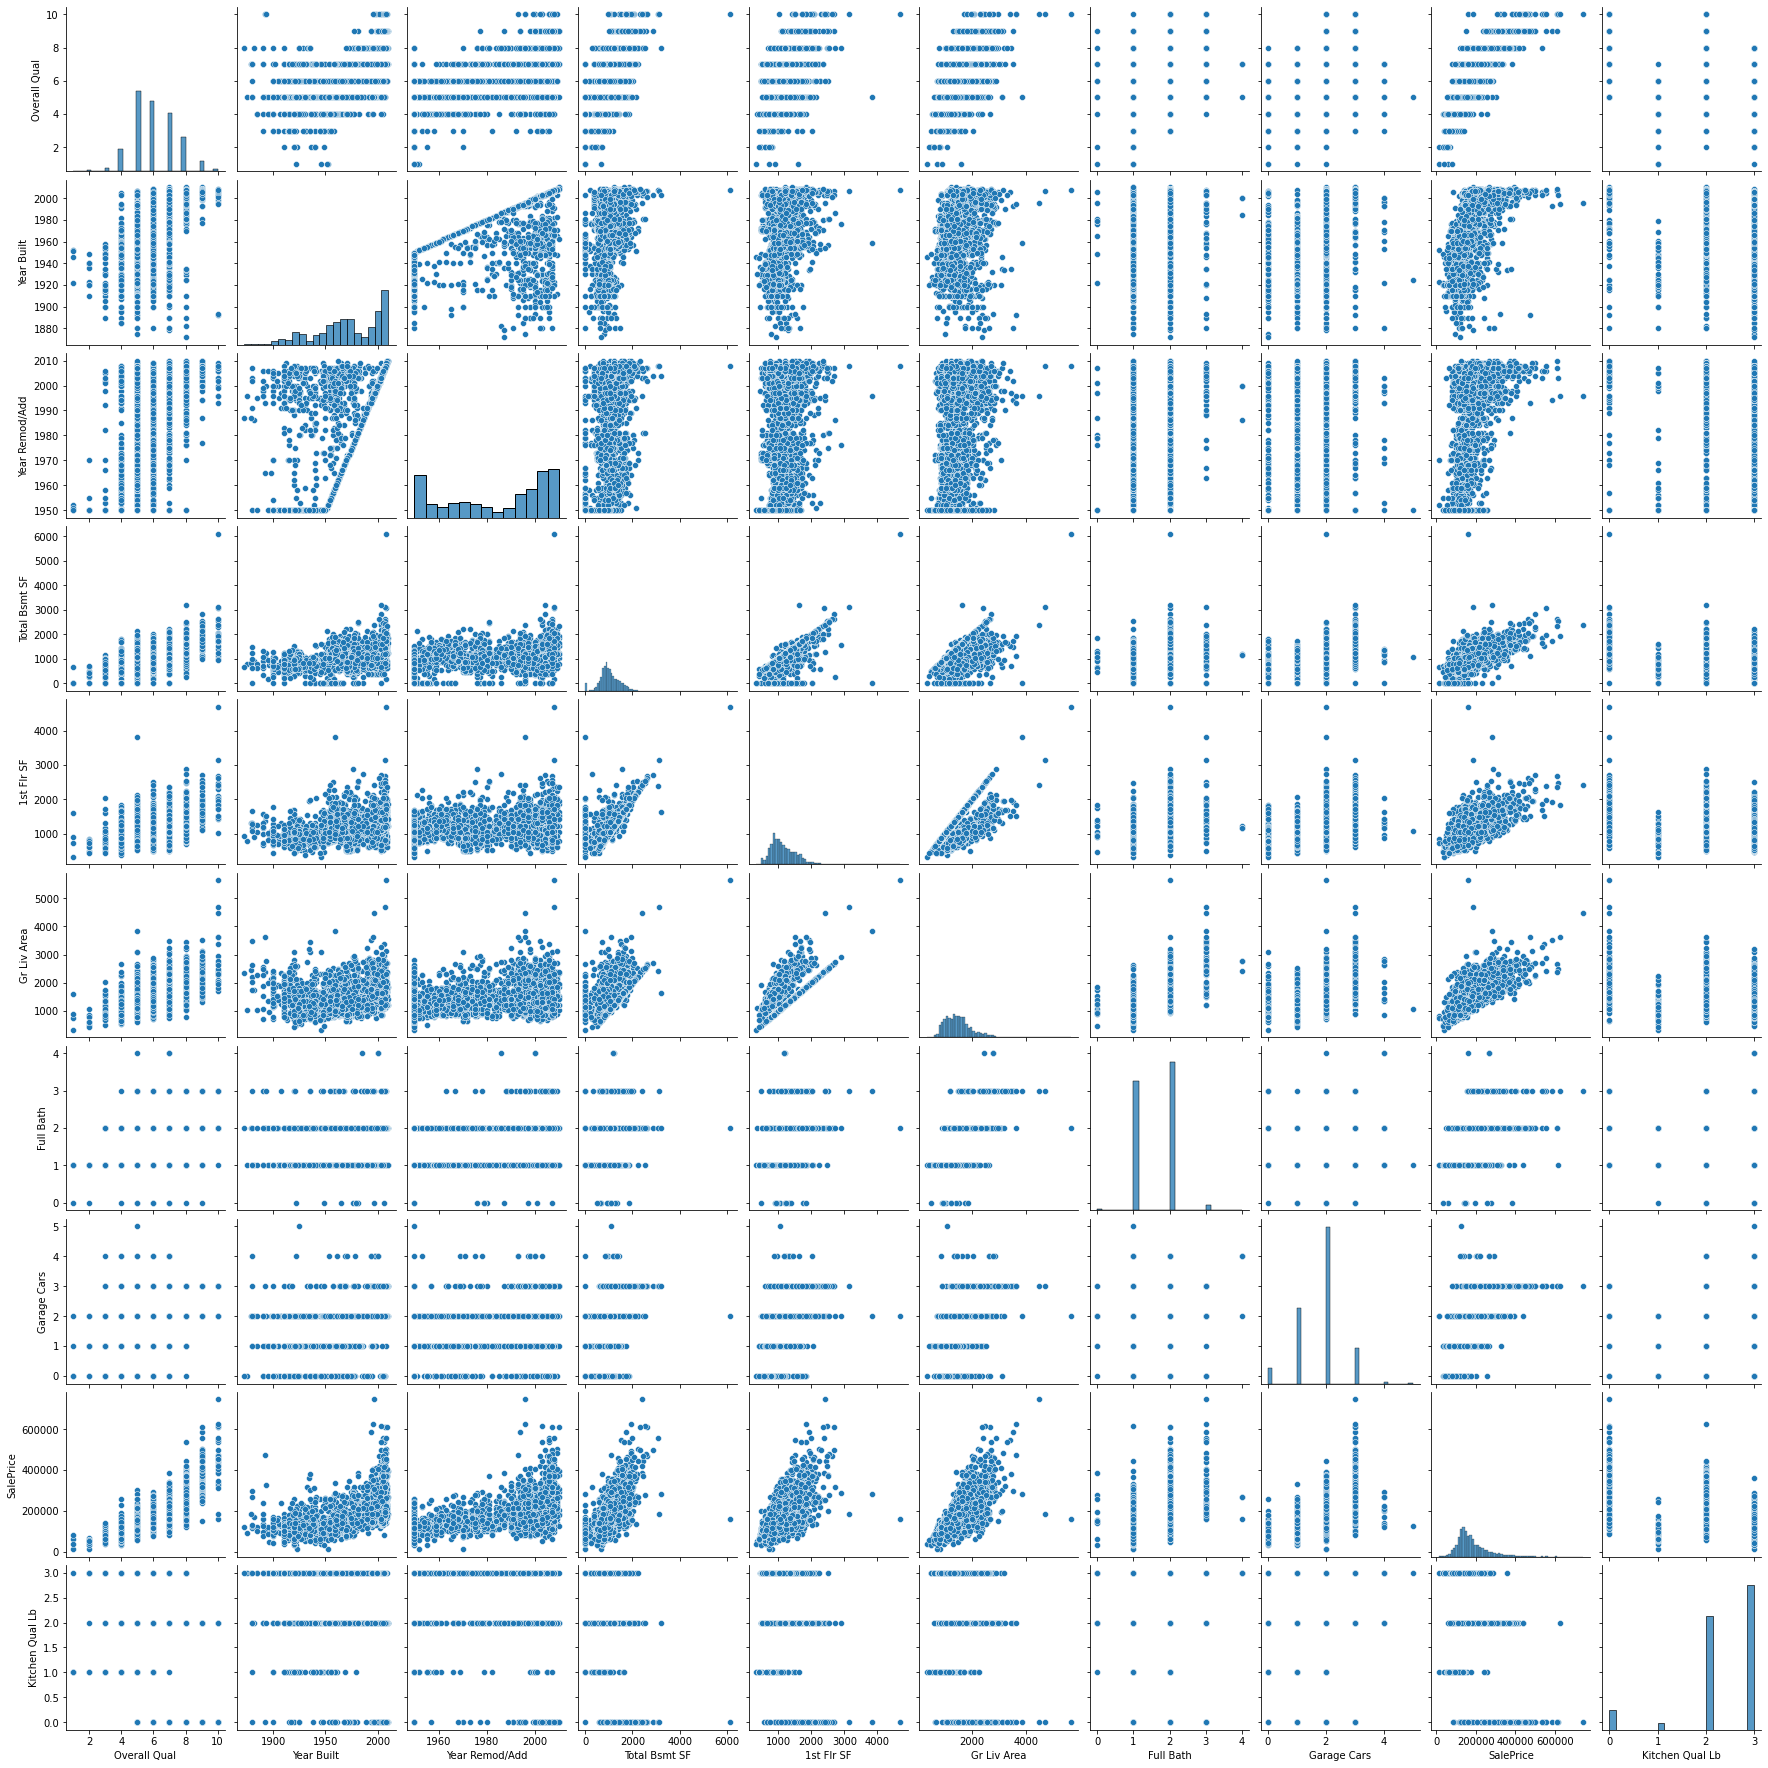

In [16]:
# well that took a long time to run.
sns.pairplot(data_enc)

### Evaluate Anomalies

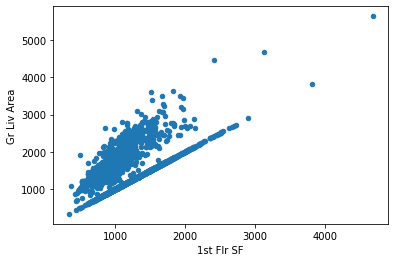

In [17]:
# Gr Liv Area = 1st Flr SF in many cases. This indicates a single story house.
data_enc.plot('1st Flr SF', 'Gr Liv Area', kind = 'scatter')

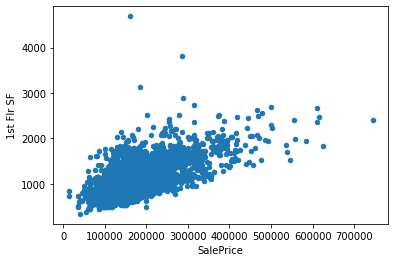

In [18]:
# Sale Price trends up when square feet increases. 
# However there are some outliers with low price and large square feet.
data_enc.plot('SalePrice', '1st Flr SF', kind = 'scatter')

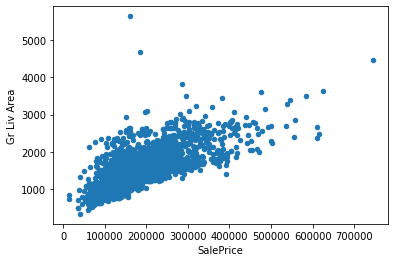

In [19]:
# TODO: put side by side with previous plot
# Sale Price trends up when square feet increases. 
# However there are some outliers with low price and large square feet.
data_enc.plot('SalePrice', 'Gr Liv Area', kind = 'scatter')

## Distributions

1. Look at distribution of SalePrice.
1. Identify average SalePrice by "Predictor" to further confirm effect predictors have on SalePrice.

Note: Can use group by for this


Text(0, 0.5, 'Count')

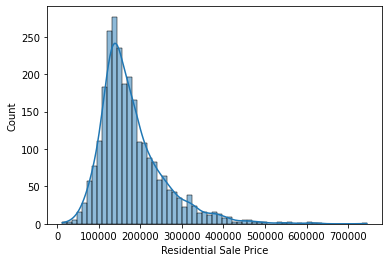

In [20]:
# Look at distribution of SalePrice
# Result indicates data is right skewed with some outliers
sns.histplot(data_enc['SalePrice'], kde=True)
plt.xlabel('Residential Sale Price')
plt.ylabel("Count")

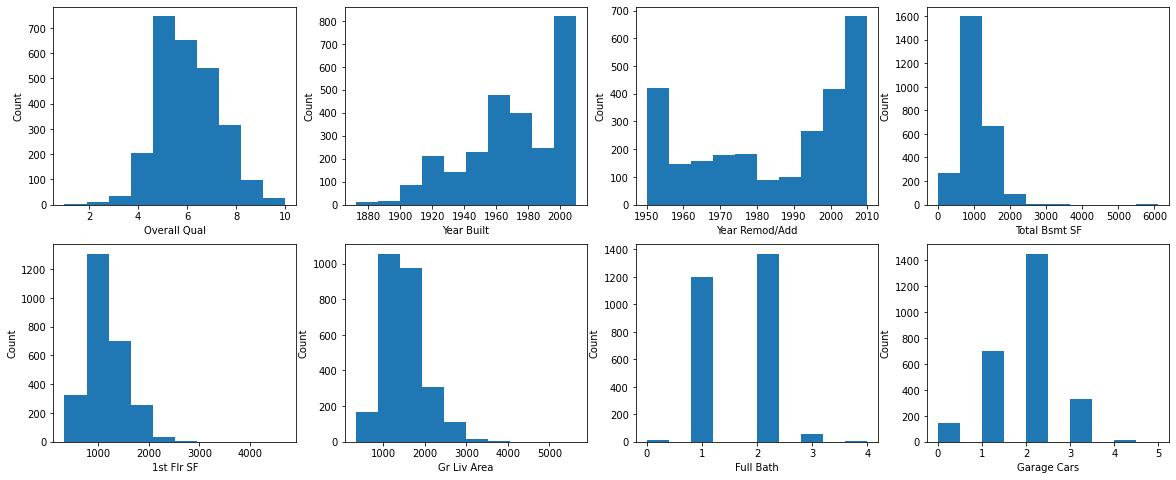

In [21]:
# Look at distributions for selected predictors
# Overall Qual        0.805016
# Gr Liv Area         0.705482
# Garage Cars         0.646874
# Kitchen Qual Lb     0.629955
# 1st Flr SF          0.618247
# Year Built          0.562777
# Full Bath           0.542386
# Year Remod/Add      0.539932
fig, axs = plt.subplots(2,4, figsize = (20,8)) # Creating 2x4 subplots because we have 8 columns in our data
column_names = data_enc.columns
n = 0
for i in range(2): # Loop through rows 
  for j in range(4): # Loop through columns
    axs[i,j].hist(data_enc[column_names[n]])
    axs[i,j].set_xlabel(column_names[n])
    axs[i,j].set_ylabel('Count')
    n = n + 1

### Observations

* Overall Quality is slightly skewed.

* Year built is strongly skewed toward newer houses built after 2000 with a normal distribution of houses built between 1940 and 2000.

* Year Remod/Add is equal to the year built if the house was *not* remodeled. So this may indicate that the year remodeled is not a useful predictor.

* Total Bsmt SF, 1st Flr SF and Gr Liv Area are skewed toward lower square footages.

 * Total Bsmt SF has some outliers.

* Full Bath and Garage Cars are discrete.


## EDA Summary

After analyzing the data, looking at correlations between predictors and correlations with SalePrice, the following predictors were chosen to model against SalePrice:

* Overall Qual
* Gr Liv Area
* Garage Cars
* Kitchen Qual Lb
* Year Built
* Full Bath


# Processing

aka Model Validation of Continuous Response

* Mean Squared Error (MSE)
 * Outliers can be more heavily weighted
* Root Mean Squared Error (RMSE)
 * Square root of MSE
 * In same units as the response
* Root Mean Squared Percentage Error (RMSPE) --> GOAL FOR THIS PROJECT
 * Scales RMSE based on the response value
* Mean Absolute Error (MAE)
 * Outliers are *not* more heavily weighted.

 [Slides](https://docs.google.com/presentation/d/1uMKqprz6tjWaGdzyXc2KAc5rGqZYdXC_/edit#slide=id.gdabdebda8f_0_61)

 [Example](https://colab.research.google.com/drive/1T59pwLHro8Hoj6hhgnAz-i4ShH5wm-jh)
 



## Feature Scaling

* Min-Max Scaling - aka Normalization
* Robust Scaling - like min-max but resistant to outliers

[Examples](https://colab.research.google.com/drive/1RxlvHBJ-Gh6tKxsRZsjW03S6owedpj6q#scrollTo=aX-z3Va86EjG)

## Regularization

Helps with overfitting (high variance, low bias) with large datasets. Shrinks regression model coefficient estimates towards zero.

* Ridge Regression
* Lasso Regression

[Slides](https://docs.google.com/presentation/d/1m2vJB58QWDLDtW-A244J4y8TcNH867j3G_UyeULUe9w/edit#slide=id.gdd52504e00_0_0)

[Examples](https://colab.research.google.com/drive/1rHyd135SB8Xk_xyALCNRsjzhavMghL5q)

## Box Cox

Transform non-normal dependent variables into a normal shape. An optimal lambda will give you the best approximation of a normal curve.



In [22]:
# QQ Plot before

# Do box cox adjustment

# QQ Plot after

# Communicate Results

Preliminary results indicate that price is affected by the following predictors:

1. Overall Qual        0.805016
1. Gr Liv Area         0.705482
1. Garage Cars         0.646874
1. Kitchen Qual Lb     0.629955
1. 1st Flr SF          0.618247
1. Year Built          0.562777
1. Full Bath           0.542386
1. Year Remod/Add      0.539932